In [1]:
%load_ext blackcellmagic

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

In [3]:
from research.strings import TARGET, PREDICTORS
from research.evaluation import evaluate_model

In [4]:
d_test = pd.read_csv("data/test_data.csv")
y_test = d_test[TARGET]
X_test = d_test[PREDICTORS]
clf = pickle.load(open("models/sklearn-glm.pkl", "rb"))
evaluate_model(y_test, clf.predict(X_test))

F1 Score = 0.08664
Precision = 0.63158
Recall = 0.04651


,Predicted +,Predicted -
Actual +,12,246
Actual -,7,1372


In [5]:
def to_inspection_daynum(date_ser):
    SECONDS = 60 * 60 * 24
    dates = date_ser.apply(lambda d: datetime.fromtimestamp(d * SECONDS))
    daynums = (dates - dates.min()).apply(lambda dt: dt.days + 1).values
    return daynums

In [6]:
def get_days_by_score(days, y_scores):
    res = pd.DataFrame()
    res["Score"] = y_scores
    ranked = res.sort_values(by="Score", ascending=False).reset_index()
    ranked["Day"] = np.sort(days)
    ranked_days = ranked.sort_values(by="index")["Day"].values
    return ranked_days

In [7]:
def get_cumulative(y_true, days):
    res = pd.DataFrame()
    res["Result"] = y_true
    res["Day"] = days
    cumsum = res.groupby("Day")["Result"].sum().cumsum()
    # Assumes that groupby.sum.cumsum is sorted by index
    total = int(cumsum.iloc[-1])
    return cumsum, total

In [8]:
def compare_cumulative(y_true, days, rankings, ax=None):
    if not ax:
        ax = plt.gca()
    pal = sns.hls_palette(len(rankings), h=0.5)
    true_total = int(y_true.sum())
    for i, (name, scores) in enumerate(rankings):
        sorted_days = get_days_by_score(days, scores)
        cumsum, total = get_cumulative(y_true, sorted_days)
        assert (
            total == true_total
        ), "Total number of critical violations found in {} ({}) does not match true total ({}).".format(
            name, total, true_total
        )
        sns.lineplot(x=cumsum.index, y=cumsum.values, label=name, color=pal[i], ax=ax)
    ax.set_xlabel("Inspection Day")
    ax.set_ylabel("Critical Violations Found")
    ax.set_title("Critical Violations Found Over Time")
    ax.legend()

In [9]:
def get_days_earlier(y_true, days, y_scores):
    sorted_days = get_days_by_score(days, y_scores)
    diff = days - sorted_days
    res = pd.DataFrame()
    res["Result"] = y_true
    res["NewDay"] = sorted_days
    res["Diff"] = diff
    crit_diff = res.query("Result > 0")["Diff"].values
    return crit_diff

In [10]:
def get_first_half_proportion(y_true, y_scores):
    res = pd.DataFrame()
    res["Result"] = y_true
    res["Score"] = y_scores
    halftime = len(y_true) / 2
    ranked = res.sort_values(by="Score", ascending=False).reset_index()
    ranked["FirstHalf"] = np.array(range(len(y_true))) < halftime
    prop = ranked.query("FirstHalf")["Result"].sum() / y_true.sum()
    return prop

In [11]:
def bin_range(vals, size):
    max_val = max(max(vals), 0)
    min_val = min(min(vals), 0)
    range_max = int(size * np.ceil(max_val / size))
    range_min = int(size * np.floor(min_val / size))
    rg = range(range_min, range_max, size)
    return rg

In [12]:
def compare_days_earlier(y_true, days, rankings, ax=None, verbose=False):
    if not ax:
        ax = plt.gca()
    bins = bin_range([-1 * days.max(), days.max()], 5)
    pal = sns.hls_palette(len(rankings), h=0.5)
    no_changes = []
    for i, (name, scores) in enumerate(rankings):
        crit_diff = get_days_earlier(y_true, days, scores)
        abs_sum = np.abs(crit_diff).sum()
        if abs_sum > 0:
            sns.distplot(crit_diff, kde=False, label=name, color=pal[i], bins=bins, ax=ax)
            ax.axvline(crit_diff.mean(), color=pal[i], linestyle="--")
        else:
            no_changes.append(name)
    ax.set_xlabel("Days Earlier")
    ax.set_ylabel("Frequency")
    ax.set_title("Change in Days to Find Critical Violations")
    ax.legend()
    if verbose:
        note = "Note: {} led to no changes in detection of critical violations."
        for name in no_changes:
            print(note.format(name))

In [13]:
def compare_stats(y_true, days, rankings):
    rows = []
    for i, (name, scores) in enumerate(rankings):
        crit_diff = get_days_earlier(y_true, days, scores)
        row = {}
        row["Model"] = name
        row["Mean Change"] = crit_diff.mean()
        row["Std. Change"] = crit_diff.std()
        row["First Half"] = get_first_half_proportion(y_true, scores)
        rows.append(row)
    cols = ["Model", "First Half", "Mean Change", "Std. Change"]
    df = pd.DataFrame(rows)
    return df[cols]

In [14]:
def compare_metrics(y_true, days, models):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    fig.set_figwidth(15)
    compare_cumulative(y_true, days, models, ax0)
    compare_days_earlier(y_true, days, models, ax1)
    plt.show()
    df = compare_stats(y_true, days, models)
    order = ["First Half", "Mean Change", "Std. Change"]
    asc = [False, False, True]
    return df.sort_values(by=order, ascending=asc).round(3)

In [15]:
def show_metrics(y_true, days, y_scores, name="Model"):
    return compare_metrics(y_true, days, [(name, y_scores)])

In [16]:
y_true = y_test.copy()
days = to_inspection_daynum(d_test["Inspection_Date"])
np.random.seed(0)
base_models = [
    ("Usual", days.max() - days),
    ("Random", np.random.rand(len(y_true))),
    ("Worst", 1 - y_true),
    ("Best", y_true)
]
y_scores = clf.predict_proba(X_test)[:,1]
models = [
    ("City Model", y_scores)
]
all_models = base_models + models

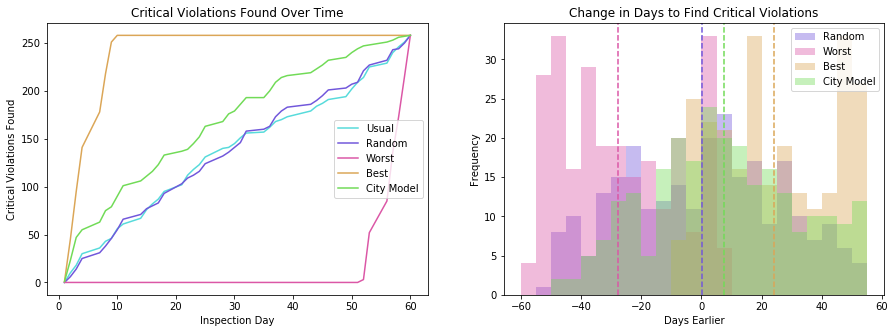

,Model,First Half,Mean Change,Std. Change
3,Best,1.000,24.058,19.390
4,City Model,0.690,7.438,25.156
0,Usual,0.554,0.000,0.000
1,Random,0.531,0.236,26.436
2,Worst,0.000,-27.659,19.049


In [17]:
compare_metrics(y_true, days, all_models)

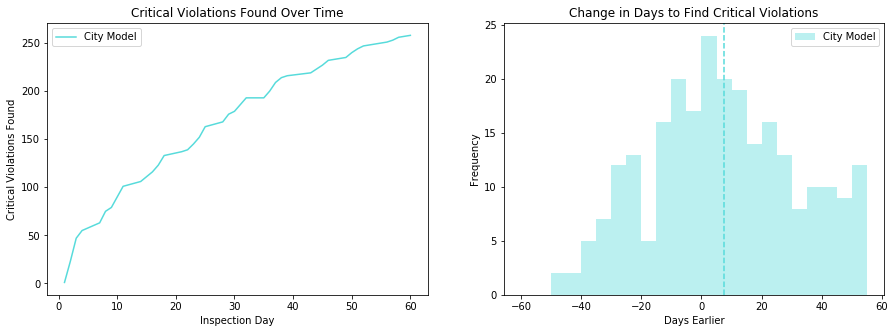

,Model,First Half,Mean Change,Std. Change
0,City Model,0.69,7.438,25.156


In [18]:
show_metrics(y_true, days, y_scores, name="City Model")